In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import reuters
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import csv

from torch.nn.utils import clip_grad_norm_
import re
import pickle
import time
from tqdm import tqdm
from collections import Counter
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import nltk
nltk.download('reuters')
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package reuters to /root/nltk_data...


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [14]:
documents = reuters.fileids()
categories = reuters.categories()

train_docs = [doc for doc in documents if doc.startswith("training/")]
test_docs = [doc for doc in documents if doc.startswith("test/")]

In [15]:
train_sentences = [reuters.raw(doc_id) for doc_id in train_docs]
train_labels = [reuters.categories(doc_id) for doc_id in train_docs]

test_sentences = [reuters.raw(doc_id) for doc_id in test_docs]
test_labels = [reuters.categories(doc_id) for doc_id in test_docs]

In [44]:
i = 373
test_sentences[i], test_labels[i]

('BRAZILIAN SOY RAINFALL\n  THE FOLLOWING RAINFALL WAS RECORDED IN\n  THE 24 HOURS UP TO (1200) GMT TODAY\n      PARANA STATE: CASCAVEL NIL, PONTA GROSSA NIL,CAMPO MOURAO\n  NIL, LONDRINA NIL, MARINGA NIL.\n      RIO GRANDO DO SUL STATE: PASSO FUNDO NIL, SANTA MARIA 7.0\n  MILLIMETRES, CRUZ ALTA 8.5 MM, SAO LUIZ GONZAGA 4.4 MM. REUTER\n  \n\n',
 ['oilseed', 'soybean'])

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size = 0.2, random_state = 42)

In [ ]:
def convert_to_labels(data_categories, unique_labels):
    binary_vectors = []
    for categories in data_categories:
        binary_vector = np.zeros(len(unique_labels), dtype=int)
        for category in categories:
            binary_vector[np.where(unique_labels == category)] = 1
        binary_vectors.append(binary_vector)

    binary_vectors = np.array(binary_vectors)
    return binary_vectors

In [ ]:
unique_labels = np.concatenate(train_labels)
unique_labels = np.unique(unique_labels)

In [ ]:
unique_labels.shape

(90,)

In [ ]:
train_labels = convert_to_labels(train_labels, unique_labels)
val_labels = convert_to_labels(val_labels, unique_labels)
test_labels = convert_to_labels(test_labels, unique_labels)

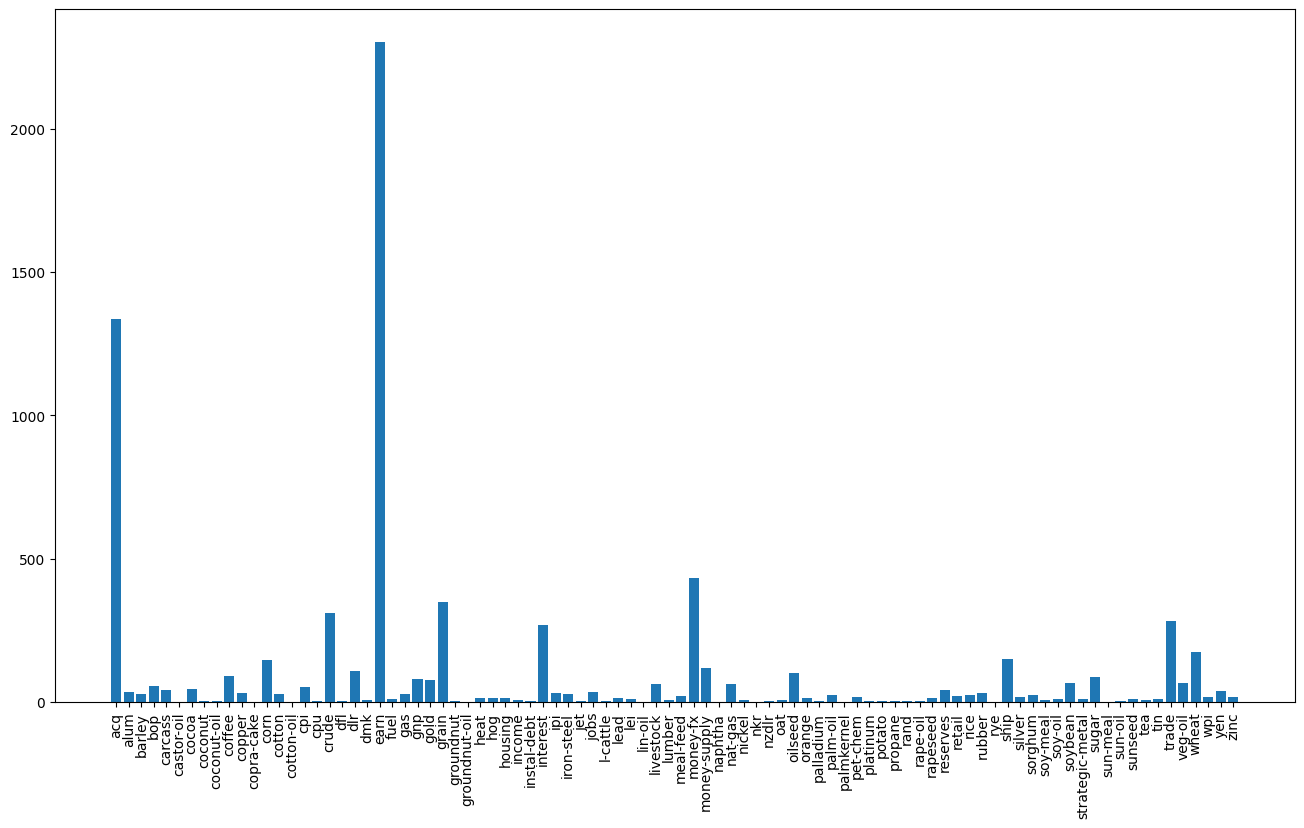

In [ ]:
labels_count = [0] * 90

for label in train_labels:
    for i in range(len(label)):
        if label[i] == 1:
            labels_count[i] += 1

fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(unique_labels, labels_count)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

In [46]:
def data_preprocessing(sentences):

    tokenized_sentences = []
    for sentence in sentences:
        sentence = sentence.lower()
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, ' ', sentence)

        sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
        sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)
        sentence = sentence.strip()
        sentence = sentence.replace("\n"," ")
        sentence = re.sub(r'[^A-Za-z ]', '', sentence)
        sentence = re.sub('\s+', ' ', sentence)

        tokenized_sentences.append(nltk.word_tokenize(sentence))

    stop_words = set(stopwords.words('english'))

    removed_stop_words = []
    for sentence in tokenized_sentences:
        curr_sentence = []
        for token in sentence:
            if not token in stop_words:
                curr_sentence.append(token)
        
        removed_stop_words.append(curr_sentence)

    lemmatizer = WordNetLemmatizer()

    lemmatized_sentence = []
    for sentence in removed_stop_words:
        curr_sentence = []
        for token in sentence:
            curr_sentence.append(lemmatizer.lemmatize(token))

        lemmatized_sentence.append(curr_sentence)

    return lemmatized_sentence

In [6]:
def vocab_builder(sentences):
    # Word dictionary
    word_vocab = {}
    unique_id = 1
    for sentence in sentences:
        for word in sentence:
            if word not in word_vocab:
                word_vocab[word] = unique_id
                unique_id += 1

    word_vocab['<PAD>'] = 0
    word_vocab['<OOV>'] = unique_id

    return word_vocab

In [47]:
def text_to_sequence(sentences, word_vocab):

    text_sequence = []
    for sentence in sentences:
        curr_sequence = []
        for word in sentence:
            if word in word_vocab:
                curr_sequence.append(word_vocab[word])
            else:
                curr_sequence.append(word_vocab['<OOV>'])
        text_sequence.append(curr_sequence)

    return text_sequence

def pad_sequences(seq, maxlen):
    padded_seq = []
    if len(seq) < maxlen:
        padding_seq = [0] * (maxlen - len(seq))
        padded_seq = padding_seq + seq
    else:
        padded_seq = seq
        
    return padded_seq


def padding(sequence, max_length):
    new_sequence = []
    for i in range(len(sequence)):
        if len(sequence[i]) <= max_length:
            new_sequence.append(sequence[i])
        else:
            new_sequence.append(sequence[i][:max_length])
            

    sequence = new_sequence

    X = []
    for seq in sequence:
        X.append(pad_sequences(seq, maxlen = max_length))

    return X

In [ ]:
max_length = 200

In [ ]:
# Train data
train_sentences = data_preprocessing(train_sentences)
word_vocab = vocab_builder(train_sentences)
vocab_size = len(word_vocab)
train_sequence = text_to_sequence(train_sentences, word_vocab)
train_sequence = padding(train_sequence, max_length)

X_train = np.array(train_sequence)
y_train = np.array(train_labels)

Padding: 100%|██████████| 6215/6215 [00:00<00:00, 151758.74it/s]


In [ ]:
# Val data
val_sentences = data_preprocessing(val_sentences)
val_sequence = text_to_sequence(val_sentences, word_vocab)
val_sequence = padding(val_sequence, max_length)

X_val = np.array(val_sequence)
y_val = np.array(val_labels)

Padding: 100%|██████████| 1554/1554 [00:00<00:00, 149576.57it/s]


In [ ]:
# Test data
test_sentences = data_preprocessing(test_sentences)
test_sequence = text_to_sequence(test_sentences, word_vocab)
test_sequence = padding(test_sequence, max_length)

X_test = np.array(test_sequence)
y_test = np.array(test_labels)

Padding: 100%|██████████| 3019/3019 [00:00<00:00, 103280.51it/s]


In [ ]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(6215, 200) (6215, 90)
(1554, 200) (1554, 90)
(3019, 200) (3019, 90)


In [ ]:
print(vocab_size, max_length)

23423 200


In [ ]:
# save word2idx, maxlength
with open('/content/drive/MyDrive/MLTC_MAGNET_REUTERS/word2idx.pkl', 'wb') as f:
    pickle.dump(word_vocab, f)

with open('/content/drive/MyDrive/MLTC_MAGNET_REUTERS/maxlength.pkl', 'wb') as f:
    pickle.dump(max_length, f)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, sequence, labels):
        self.sequence = sequence
        self.labels = labels

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, idx):
        sequence_in = torch.tensor(self.sequence[idx])
        output_label = torch.tensor(self.labels[idx]).float()
        return sequence_in, output_label

In [ ]:
batch_size = 64

dataset_train = CustomDataset(X_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(X_val, y_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = CustomDataset(X_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
def load_embeddings(embeddings_file):
    embeddings_index = {}
    with open(embeddings_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

embeddings_file = '/content/drive/MyDrive/glove.6B.300d.txt'
embeddings_index = load_embeddings(embeddings_file)

In [ ]:
embeddings_dim = 300
pretrained_embeddings = []
for word in word_vocab:
    if word in embeddings_index:
        pretrained_embeddings.append(embeddings_index.get(word))
    else:
        pretrained_embeddings.append([0] * embeddings_dim)

pretrained_embeddings = torch.Tensor(pretrained_embeddings)

<ipython-input-52-391f232f457b>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  pretrained_embeddings = torch.Tensor(pretrained_embeddings)


In [8]:
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, slope):
        super(GraphAttentionLayer, self).__init__()
        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Linear(out_features * 2, 1, bias=False)
        self.leakyrelu = nn.LeakyReLU(slope)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, h, adj):
        Wh = self.W(h)
        num_nodes = Wh.size(0)
        Whi = Wh.repeat_interleave(num_nodes, dim=0)
        Whj = Wh.repeat(num_nodes, 1)
        WhiWhj = torch.cat([Whi, Whj], dim=1)
        Whcat = WhiWhj.view(num_nodes, num_nodes, Wh.size(1) * 2)
        e = self.leakyrelu(self.a(Whcat).squeeze(2))
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = self.softmax(attention)
        h_hat = torch.mm(attention, Wh)
        return h_hat


class MAGNET(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        adjacency_matrix,
        node_embeddings,
        num_heads=4,
        slope=0.01,
        dropout=0.3,
    ):

        super(MAGNET, self).__init__()

        self.node_embedding = nn.Embedding.from_pretrained(node_embeddings)

        self.rnn = nn.LSTM(
            input_size, hidden_size, batch_first=True, bidirectional=True
        )

        self.attentions1 = nn.ModuleList(
            [
                GraphAttentionLayer(input_size, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh1 = nn.Tanh()

        self.attentions2 = nn.ModuleList(
            [
                GraphAttentionLayer(hidden_size * 2, hidden_size * 2, slope)
                for _ in range(num_heads)
            ]
        )

        self.tanh2 = nn.Tanh()

        self.adjacency_matrix = nn.Parameter(adjacency_matrix)

        self.dropout = nn.Dropout(dropout)

    def forward(self, tokens, label_embedding):

        node_features = self.node_embedding(tokens).float()

        lstm_output, (hidden, _) = self.rnn(node_features)

        hidden_state = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], dim=1)

        hidden_state = self.dropout(hidden_state)

        heads_out1 = [
            att(label_embedding, self.adjacency_matrix) for att in self.attentions1
        ]

        head_out1_mean = self.tanh1(torch.stack(heads_out1, dim=0).mean(0))

        heads_out2 = [
            att(head_out1_mean, self.adjacency_matrix) for att in self.attentions2
        ]

        head_out2_mean = self.tanh2(torch.stack(heads_out2, dim=0).mean(0))

        attention = self.dropout(head_out2_mean)

        attention = attention.transpose(0, 1)

        output = torch.mm(hidden_state, attention)

        return output

In [ ]:
def train_model(model, label_embedding, loss_function, optimizer, epochs, device, model_path):

    train_loss, val_loss = [], []
    total_time = 0
    min_average_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()

        print("Epoch : ", epoch + 1)

        model.to(device)
        model.train()
        total_train_loss = 0
        y_true_train, y_pred_train = [], []
        for batch in tqdm(dataloader_train, desc='Training'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            model.zero_grad()
            pred_batch = model(sequence_in, label_embedding)
            loss = loss_function(pred_batch, output_label)
            total_train_loss += loss.item()

            y_true_train.extend(output_label.cpu().detach().numpy().tolist())
            y_pred_train.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

            loss.backward()
            
            clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
        

        model.eval()        
        total_val_loss = 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for batch in tqdm(dataloader_val, desc='Evaluate'):
                sequence_in, output_label = batch
                sequence_in, output_label = sequence_in.to(device), output_label.to(device)

                pred_batch = model(sequence_in, label_embedding)
                loss = loss_function(pred_batch, output_label)
                total_val_loss += loss.item()

                y_true_val.extend(output_label.cpu().detach().numpy().tolist())
                y_pred_val.extend(torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist())

        y_true_train = np.array(y_true_train)
        y_pred_train = np.array(y_pred_train)
        y_true_val = np.array(y_true_val)
        y_pred_val = np.array(y_pred_val)

        y_pred_train = y_pred_train >= 0.5
        y_pred_val = y_pred_val >= 0.5

        train_f1_score_micro = metrics.f1_score(y_true_train, y_pred_train, average='micro')
        val_f1_score_micro = metrics.f1_score(y_true_val, y_pred_val, average='micro')

        average_train_loss = float(total_train_loss / len(dataloader_train))
        average_val_loss = float(total_val_loss / len(dataloader_val))

        print('Train F1 Score (Micro)', train_f1_score_micro)
        print('Val F1 Score (Micro)', val_f1_score_micro)
        print('Train loss', average_train_loss)
        print('Val loss', average_val_loss)

        train_loss.append(average_train_loss)
        val_loss.append(average_val_loss)

        if average_val_loss < min_average_loss:
            min_average_loss = average_val_loss
            torch.save(model, "/content/drive/MyDrive/MLTC_MAGNET_REUTERS/" + model_path)
            print("Best model saved")
            
        print("------------------------------------------------")

        end_time = time.time()
        epoch_time = end_time - start_time
        total_time += epoch_time

    avg_epoch_time = total_time / epochs
    return train_loss, val_loss, avg_epoch_time

In [ ]:
def buildAdjacencyCOOC(data_label):
  adj = data_label.T.dot(data_label).astype('float')
  
  for i in range(len(adj)):
    adj[i] = adj[i] / adj[i,i]
  
  return torch.from_numpy(adj.astype('float32'))

In [ ]:
adjacency = buildAdjacencyCOOC(y_train)

In [ ]:
label_embedding = torch.zeros(90, 300)

defined_labels = ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa',
       'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn',
       'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk',
       'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
       'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead',
       'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx',
       'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nz-dlr',
       'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palm-kernel',
       'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil',
       'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship',
       'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sun-seed',
       'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']

for index, label in enumerate(defined_labels):
  words = label.split('-')
  num_of_words = len(words)
  
  for sublabel in words:
    if sublabel in embeddings_index.keys():
      label_embedding[index] +=  torch.from_numpy(embeddings_index[sublabel])
  label_embedding[index] = label_embedding[index]/num_of_words

label_embedding = label_embedding.float().to(device)
print(label_embedding, label_embedding.shape)

tensor([[ 0.1796, -0.1051, -0.5564,  ..., -0.0633,  0.3732, -0.2873],
        [ 0.1101,  0.4061,  0.2036,  ..., -0.1957, -0.4627,  0.6931],
        [-0.3568, -0.1348,  0.0790,  ..., -0.0384,  0.2948,  0.1996],
        ...,
        [-0.1446,  0.0594, -0.1450,  ..., -0.0334,  0.1966,  0.4136],
        [-0.5990, -0.3234, -0.2749,  ...,  0.6343,  0.5300,  0.0299],
        [-0.4541, -0.1300, -0.5178,  ..., -1.1637, -0.2056, -0.3177]],
       device='cuda:0') torch.Size([90, 300])


In [ ]:
with open('/content/drive/MyDrive/MLTC_MAGNET_REUTERS/label_embedding.pkl', 'wb') as f:
    pickle.dump(label_embedding, f)

In [ ]:
for word in label_embedding : 
    if(word[0] == 0) :
        print("Zero Labelling Check")

In [ ]:
epochs = 50
learning_rate = 0.001

magnet_model_head_4 = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 4)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_head_4.parameters(), lr = learning_rate)
train_loss_4, val_loss_4, avg_epoch_time_4 = train_model(magnet_model_head_4, label_embedding, loss_function, optimizer, epochs, device, "reuters_head4.pth")

Epoch :  1


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.23it/s]


Train F1 Score (Micro) 0.04579698651863599
Val F1 Score (Micro) 0.30873049346267395
Train loss 0.08141147459343988
Val loss 0.05005224615335464
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 48.66it/s]


Train F1 Score (Micro) 0.34479155783094767
Val F1 Score (Micro) 0.39150354019158684
Train loss 0.04576141396727489
Val loss 0.04226580888032913
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 51.77it/s]


Train F1 Score (Micro) 0.4029194161167767
Val F1 Score (Micro) 0.39188069594034797
Train loss 0.04032526444643736
Val loss 0.038788714036345484
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 48.14it/s]


Train F1 Score (Micro) 0.48850262538475464
Val F1 Score (Micro) 0.5661811272957568
Train loss 0.03590980396434969
Val loss 0.03639157734811306
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 52.62it/s]


Train F1 Score (Micro) 0.548841979318007
Val F1 Score (Micro) 0.5566130620282246
Train loss 0.034036317802205375
Val loss 0.03451202042400837
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 51.71it/s]


Train F1 Score (Micro) 0.5827222924568057
Val F1 Score (Micro) 0.6125636672325976
Train loss 0.030980446661005214
Val loss 0.029470517002046108
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 30.03it/s]


Train F1 Score (Micro) 0.6146486308149126
Val F1 Score (Micro) 0.6067104808024905
Train loss 0.029289874742377778
Val loss 0.02989920012652874
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 52.43it/s]


Train F1 Score (Micro) 0.6475310143517391
Val F1 Score (Micro) 0.6412263535551206
Train loss 0.027445216853247613
Val loss 0.030327790156006812
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 47.42it/s]


Train F1 Score (Micro) 0.625425101214575
Val F1 Score (Micro) 0.6267826086956522
Train loss 0.02808466069020179
Val loss 0.0290288295596838
Best model saved
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 52.26it/s]


Train F1 Score (Micro) 0.6705358562569567
Val F1 Score (Micro) 0.6802418071905822
Train loss 0.02539785491416649
Val loss 0.026033901013433933
Best model saved
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 51.07it/s]


Train F1 Score (Micro) 0.6918131825575091
Val F1 Score (Micro) 0.6355785837651122
Train loss 0.023869422216880685
Val loss 0.027735757604241372
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 47.39it/s]


Train F1 Score (Micro) 0.7196697500191117
Val F1 Score (Micro) 0.7206427688504328
Train loss 0.022077698583657643
Val loss 0.023695678636431693
Best model saved
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.82it/s]


Train F1 Score (Micro) 0.728713768115942
Val F1 Score (Micro) 0.6947100063734863
Train loss 0.02156923076480019
Val loss 0.024890454709529875
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 46.90it/s]


Train F1 Score (Micro) 0.7253065265402482
Val F1 Score (Micro) 0.7114093959731543
Train loss 0.0221134331362436
Val loss 0.024012610539793967
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.16it/s]


Train F1 Score (Micro) 0.7536145029590232
Val F1 Score (Micro) 0.6963455149501663
Train loss 0.019336894458653976
Val loss 0.025462888292968274
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.57it/s]


Train F1 Score (Micro) 0.765328008283411
Val F1 Score (Micro) 0.7351485148514852
Train loss 0.018303755870355026
Val loss 0.02226079996675253
Best model saved
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.81it/s]


Train F1 Score (Micro) 0.7812660080497621
Val F1 Score (Micro) 0.7484624846248461
Train loss 0.016951969729698434
Val loss 0.02200220089405775
Best model saved
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.87it/s]


Train F1 Score (Micro) 0.7661344225770516
Val F1 Score (Micro) 0.7297554779295014
Train loss 0.018075883060655728
Val loss 0.021941843815147875
Best model saved
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 46.87it/s]


Train F1 Score (Micro) 0.7546446475965792
Val F1 Score (Micro) 0.6970387243735763
Train loss 0.018941959109613483
Val loss 0.02489628527313471
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.16it/s]


Train F1 Score (Micro) 0.7709773670038571
Val F1 Score (Micro) 0.7527141133896261
Train loss 0.017499985429933484
Val loss 0.021651497073471547
Best model saved
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 46.99it/s]


Train F1 Score (Micro) 0.8058886894075403
Val F1 Score (Micro) 0.7519902020820577
Train loss 0.015053287214998688
Val loss 0.02164281064644456
Best model saved
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.16it/s]


Train F1 Score (Micro) 0.8130104395994602
Val F1 Score (Micro) 0.7297128589263421
Train loss 0.014735520375436363
Val loss 0.02398192062973976
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.11it/s]


Train F1 Score (Micro) 0.819613965370423
Val F1 Score (Micro) 0.7178885630498534
Train loss 0.014441191518147076
Val loss 0.023884870670735837
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.74it/s]


Train F1 Score (Micro) 0.8096856414613425
Val F1 Score (Micro) 0.7689519782543038
Train loss 0.014584889017729735
Val loss 0.021483567021787168
Best model saved
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.46it/s]


Train F1 Score (Micro) 0.8374570687600758
Val F1 Score (Micro) 0.7825831126802002
Train loss 0.012267787285073072
Val loss 0.020949321649968624
Best model saved
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 47.66it/s]


Train F1 Score (Micro) 0.8564077602392045
Val F1 Score (Micro) 0.7904018502457358
Train loss 0.011135501651644555
Val loss 0.020327341854572297
Best model saved
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.42it/s]


Train F1 Score (Micro) 0.8624371426603294
Val F1 Score (Micro) 0.7858009708737865
Train loss 0.010697013190092176
Val loss 0.02073057271540165
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 47.76it/s]


Train F1 Score (Micro) 0.8682712747719948
Val F1 Score (Micro) 0.8005908419497784
Train loss 0.01025758409511526
Val loss 0.020248115137219427
Best model saved
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.89it/s]


Train F1 Score (Micro) 0.8676914630798792
Val F1 Score (Micro) 0.7780821917808218
Train loss 0.010286926016287536
Val loss 0.02238345954567194
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.20it/s]


Train F1 Score (Micro) 0.8805203697363917
Val F1 Score (Micro) 0.8000000000000002
Train loss 0.009546563875082195
Val loss 0.021328187212347985
------------------------------------------------
Epoch :  31


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.42it/s]


Train F1 Score (Micro) 0.8855327000615048
Val F1 Score (Micro) 0.7970353477765107
Train loss 0.008927048523720277
Val loss 0.020131136775016784
Best model saved
------------------------------------------------
Epoch :  32


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 51.00it/s]


Train F1 Score (Micro) 0.8981111637668404
Val F1 Score (Micro) 0.804
Train loss 0.007982002821874482
Val loss 0.02095161136239767
------------------------------------------------
Epoch :  33


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 48.24it/s]


Train F1 Score (Micro) 0.893048491013903
Val F1 Score (Micro) 0.7787296898079763
Train loss 0.008364781064969696
Val loss 0.02208382297307253
------------------------------------------------
Epoch :  34


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.88it/s]


Train F1 Score (Micro) 0.8890997830802603
Val F1 Score (Micro) 0.8081277213352686
Train loss 0.00845653008745641
Val loss 0.02210164997726679
------------------------------------------------
Epoch :  35


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 47.29it/s]


Train F1 Score (Micro) 0.8758769562871019
Val F1 Score (Micro) 0.7967615857063093
Train loss 0.00979120538056809
Val loss 0.02214322529733181
------------------------------------------------
Epoch :  36


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.86it/s]


Train F1 Score (Micro) 0.8951623770381352
Val F1 Score (Micro) 0.806432400238237
Train loss 0.008177164523881309
Val loss 0.02274710439145565
------------------------------------------------
Epoch :  37


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.21it/s]


Train F1 Score (Micro) 0.8963933540456572
Val F1 Score (Micro) 0.8225852679850961
Train loss 0.007987227378774206
Val loss 0.021052464712411165
------------------------------------------------
Epoch :  38


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.48it/s]


Train F1 Score (Micro) 0.9089315807212671
Val F1 Score (Micro) 0.7554479418886199
Train loss 0.007157334649213114
Val loss 0.025673911273479462
------------------------------------------------
Epoch :  39


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 48.86it/s]


Train F1 Score (Micro) 0.9060024170807036
Val F1 Score (Micro) 0.8100294985250737
Train loss 0.006983826331300091
Val loss 0.022703311182558538
------------------------------------------------
Epoch :  40


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 47.92it/s]


Train F1 Score (Micro) 0.9159855286077985
Val F1 Score (Micro) 0.8058737151248164
Train loss 0.006622954718388465
Val loss 0.021766466218978167
------------------------------------------------
Epoch :  41


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.70it/s]


Train F1 Score (Micro) 0.9151429910923582
Val F1 Score (Micro) 0.8193191736979923
Train loss 0.0066270145886976805
Val loss 0.02152756191790104
------------------------------------------------
Epoch :  42


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.19it/s]


Train F1 Score (Micro) 0.9195187165775401
Val F1 Score (Micro) 0.8203828828828829
Train loss 0.0061543705274483985
Val loss 0.02189983207732439
------------------------------------------------
Epoch :  43


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.52it/s]


Train F1 Score (Micro) 0.9196351288368066
Val F1 Score (Micro) 0.8193473193473194
Train loss 0.005995537070777239
Val loss 0.023537573777139185
------------------------------------------------
Epoch :  44


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.81it/s]


Train F1 Score (Micro) 0.9210122187353943
Val F1 Score (Micro) 0.7834240774349668
Train loss 0.0062275002116565495
Val loss 0.024971102736890315
------------------------------------------------
Epoch :  45


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.42it/s]


Train F1 Score (Micro) 0.9216117216117217
Val F1 Score (Micro) 0.8106215348701489
Train loss 0.006023146509078844
Val loss 0.023619651235640048
------------------------------------------------
Epoch :  46


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.97it/s]


Train F1 Score (Micro) 0.933182784272051
Val F1 Score (Micro) 0.8272311212814645
Train loss 0.005135484462679953
Val loss 0.023191550752380864
------------------------------------------------
Epoch :  47


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 46.45it/s]


Train F1 Score (Micro) 0.9321314952279958
Val F1 Score (Micro) 0.8105906313645621
Train loss 0.005449149535484232
Val loss 0.02568538151681423
------------------------------------------------
Epoch :  48


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.60it/s]


Train F1 Score (Micro) 0.9357517772905455
Val F1 Score (Micro) 0.8151796060254924
Train loss 0.0048523899948827885
Val loss 0.025460207015275956
------------------------------------------------
Epoch :  49


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 50.17it/s]


Train F1 Score (Micro) 0.9269005847953217
Val F1 Score (Micro) 0.818732782369146
Train loss 0.005892021818815882
Val loss 0.024495223090052604
------------------------------------------------
Epoch :  50


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 49.83it/s]


Train F1 Score (Micro) 0.9240472712787146
Val F1 Score (Micro) 0.8186046511627906
Train loss 0.006069077166956754
Val loss 0.025519338957965373
------------------------------------------------


In [ ]:
epochs = 50
learning_rate = 0.001

magnet_model_head_2 = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 2)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_head_2.parameters(), lr = learning_rate)
train_loss_2, val_loss_2, avg_epoch_time_2 = train_model(magnet_model_head_2, label_embedding, loss_function, optimizer, epochs, device, "reuters_head2.pth")

Epoch :  1


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.16it/s]


Train F1 Score (Micro) 0.06814962925935182
Val F1 Score (Micro) 0.27142857142857146
Train loss 0.07774770645690816
Val loss 0.051780860871076584
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 56.10it/s]


Train F1 Score (Micro) 0.374059181358903
Val F1 Score (Micro) 0.37090599744789454
Train loss 0.04670110918885591
Val loss 0.04331370517611503
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.47it/s]


Train F1 Score (Micro) 0.41089939776878276
Val F1 Score (Micro) 0.3981674302374011
Train loss 0.04133915435522795
Val loss 0.03766817547380924
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 59.98it/s]


Train F1 Score (Micro) 0.44640653185227375
Val F1 Score (Micro) 0.4998165137614679
Train loss 0.03869623413347468
Val loss 0.03597091071307659
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 56.21it/s]


Train F1 Score (Micro) 0.5355944179473592
Val F1 Score (Micro) 0.5959657701711492
Train loss 0.03411055928362267
Val loss 0.03435802981257439
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 59.53it/s]


Train F1 Score (Micro) 0.5216156236129604
Val F1 Score (Micro) 0.5447272727272726
Train loss 0.034139559851313124
Val loss 0.032830739468336104
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 62.49it/s]


Train F1 Score (Micro) 0.583711167086482
Val F1 Score (Micro) 0.4987792117195675
Train loss 0.03081667411844341
Val loss 0.039776275902986526
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.19it/s]


Train F1 Score (Micro) 0.5611742745630408
Val F1 Score (Micro) 0.5869442881260551
Train loss 0.032097459143521835
Val loss 0.034598281458020214
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.43it/s]


Train F1 Score (Micro) 0.5814578434665771
Val F1 Score (Micro) 0.5607142857142857
Train loss 0.032449001959544053
Val loss 0.03319225385785103
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 56.03it/s]


Train F1 Score (Micro) 0.6496018202502845
Val F1 Score (Micro) 0.6445561139028476
Train loss 0.026790135445035234
Val loss 0.02703535370528698
Best model saved
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.87it/s]


Train F1 Score (Micro) 0.6826148744670772
Val F1 Score (Micro) 0.6883451384417258
Train loss 0.0246426454384108
Val loss 0.02628113850951195
Best model saved
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.51it/s]


Train F1 Score (Micro) 0.7087566896765686
Val F1 Score (Micro) 0.6889325474787164
Train loss 0.02294361125677824
Val loss 0.025378522872924806
Best model saved
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 57.25it/s]


Train F1 Score (Micro) 0.7215764760218614
Val F1 Score (Micro) 0.6910769230769231
Train loss 0.021885854315620904
Val loss 0.026350732147693633
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 58.25it/s]


Train F1 Score (Micro) 0.7051135931920066
Val F1 Score (Micro) 0.6181818181818182
Train loss 0.022603886510834705
Val loss 0.02826389454305172
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.83it/s]


Train F1 Score (Micro) 0.6864355231143552
Val F1 Score (Micro) 0.6487322201607916
Train loss 0.023475504404276003
Val loss 0.031793949082493785
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.77it/s]


Train F1 Score (Micro) 0.7319008759451973
Val F1 Score (Micro) 0.7314958191390523
Train loss 0.0209386078165654
Val loss 0.022690241262316703
Best model saved
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.20it/s]


Train F1 Score (Micro) 0.7593471810089021
Val F1 Score (Micro) 0.725717776420281
Train loss 0.018904653738956063
Val loss 0.023187760487198828
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 55.61it/s]


Train F1 Score (Micro) 0.7724056603773585
Val F1 Score (Micro) 0.7227722772277227
Train loss 0.017524903174489737
Val loss 0.02382672231644392
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.24it/s]


Train F1 Score (Micro) 0.7718553228876849
Val F1 Score (Micro) 0.7276166456494325
Train loss 0.01798903362407368
Val loss 0.023290068730711936
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.80it/s]


Train F1 Score (Micro) 0.7839123540435345
Val F1 Score (Micro) 0.7071895424836602
Train loss 0.017140260621981353
Val loss 0.022874478548765183
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 57.28it/s]


Train F1 Score (Micro) 0.7934289213920313
Val F1 Score (Micro) 0.7516158818097877
Train loss 0.01529276131994414
Val loss 0.02145512405782938
Best model saved
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.83it/s]


Train F1 Score (Micro) 0.8006566269359788
Val F1 Score (Micro) 0.7401477832512314
Train loss 0.014909970654858922
Val loss 0.022842130810022353
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.07it/s]


Train F1 Score (Micro) 0.8160420962810211
Val F1 Score (Micro) 0.7657415696806923
Train loss 0.014327171325151409
Val loss 0.02083466522395611
Best model saved
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 55.22it/s]


Train F1 Score (Micro) 0.8269501548859475
Val F1 Score (Micro) 0.7629170357248302
Train loss 0.013275431616383851
Val loss 0.0225253040343523
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.37it/s]


Train F1 Score (Micro) 0.8228683803905041
Val F1 Score (Micro) 0.7575210589651022
Train loss 0.013478560178369587
Val loss 0.022157115302979945
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.63it/s]


Train F1 Score (Micro) 0.8399496785015377
Val F1 Score (Micro) 0.742963192081658
Train loss 0.011965219468372514
Val loss 0.02330404918640852
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.50it/s]


Train F1 Score (Micro) 0.8461218260024975
Val F1 Score (Micro) 0.7865734265734267
Train loss 0.011646016467628735
Val loss 0.02057505164295435
Best model saved
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.85it/s]


Train F1 Score (Micro) 0.8448180050013893
Val F1 Score (Micro) 0.7802132701421801
Train loss 0.012057121567504138
Val loss 0.021895823255181312
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 57.56it/s]


Train F1 Score (Micro) 0.8319104268719384
Val F1 Score (Micro) 0.7749099639855943
Train loss 0.013298921263301554
Val loss 0.023099837228655815
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 59.82it/s]


Train F1 Score (Micro) 0.8584619625137816
Val F1 Score (Micro) 0.7812962414915656
Train loss 0.011044853309891661
Val loss 0.022172528244554998
------------------------------------------------
Epoch :  31


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 62.63it/s]


Train F1 Score (Micro) 0.8206090947017105
Val F1 Score (Micro) 0.7649208282582216
Train loss 0.013739814872530346
Val loss 0.023525052405893802
------------------------------------------------
Epoch :  32


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 55.87it/s]


Train F1 Score (Micro) 0.8376363385337567
Val F1 Score (Micro) 0.7724803862401932
Train loss 0.0120648715683088
Val loss 0.021061215549707413
------------------------------------------------
Epoch :  33


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 62.32it/s]


Train F1 Score (Micro) 0.846957845919568
Val F1 Score (Micro) 0.7822835777969513
Train loss 0.011147366019977942
Val loss 0.022751383706927298
------------------------------------------------
Epoch :  34


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.14it/s]


Train F1 Score (Micro) 0.8600411240575736
Val F1 Score (Micro) 0.7758869339486587
Train loss 0.01027127941452651
Val loss 0.023076198138296602
------------------------------------------------
Epoch :  35


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 58.94it/s]


Train F1 Score (Micro) 0.8624371426603294
Val F1 Score (Micro) 0.7935429056924383
Train loss 0.010550611258047272
Val loss 0.019851726554334162
Best model saved
------------------------------------------------
Epoch :  36


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.26it/s]


Train F1 Score (Micro) 0.8751873552255076
Val F1 Score (Micro) 0.7889087656529516
Train loss 0.009345222597143479
Val loss 0.02263648260384798
------------------------------------------------
Epoch :  37


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.87it/s]


Train F1 Score (Micro) 0.8817233621923786
Val F1 Score (Micro) 0.7898912724066999
Train loss 0.008958160544612579
Val loss 0.02291043572127819
------------------------------------------------
Epoch :  38


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.59it/s]


Train F1 Score (Micro) 0.8815843201306656
Val F1 Score (Micro) 0.792814371257485
Train loss 0.009032552657953026
Val loss 0.021785878762602805
------------------------------------------------
Epoch :  39


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.77it/s]


Train F1 Score (Micro) 0.8818219121871153
Val F1 Score (Micro) 0.7725930301240401
Train loss 0.009195951055925416
Val loss 0.024547537975013255
------------------------------------------------
Epoch :  40


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 55.15it/s]


Train F1 Score (Micro) 0.8906197087707415
Val F1 Score (Micro) 0.7991742848717194
Train loss 0.008189769611427826
Val loss 0.021525974930264057
------------------------------------------------
Epoch :  41


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.99it/s]


Train F1 Score (Micro) 0.8940060954961057
Val F1 Score (Micro) 0.7966854098845811
Train loss 0.007787421721090771
Val loss 0.02366462804377079
------------------------------------------------
Epoch :  42


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 59.97it/s]


Train F1 Score (Micro) 0.895516331913167
Val F1 Score (Micro) 0.7999999999999999
Train loss 0.0074555623298748494
Val loss 0.023360364101827145
------------------------------------------------
Epoch :  43


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 56.90it/s]


Train F1 Score (Micro) 0.8879269529928981
Val F1 Score (Micro) 0.7925840092699885
Train loss 0.008155200101805813
Val loss 0.02225987769663334
------------------------------------------------
Epoch :  44


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.71it/s]


Train F1 Score (Micro) 0.8736084713548737
Val F1 Score (Micro) 0.7965014577259474
Train loss 0.009645465642631966
Val loss 0.022063096556812524
------------------------------------------------
Epoch :  45


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.48it/s]


Train F1 Score (Micro) 0.896894743917193
Val F1 Score (Micro) 0.8037383177570093
Train loss 0.00776990856357603
Val loss 0.022551669254899025
------------------------------------------------
Epoch :  46


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.50it/s]


Train F1 Score (Micro) 0.8829635660492571
Val F1 Score (Micro) 0.8012746234067206
Train loss 0.00884024217981389
Val loss 0.023082280680537224
------------------------------------------------
Epoch :  47


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.62it/s]


Train F1 Score (Micro) 0.9028486965869389
Val F1 Score (Micro) 0.7866157910184914
Train loss 0.007076780665760898
Val loss 0.02492829576134682
------------------------------------------------
Epoch :  48


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 54.71it/s]


Train F1 Score (Micro) 0.909542676784635
Val F1 Score (Micro) 0.803830528148578
Train loss 0.006980952063138235
Val loss 0.023383577428758143
------------------------------------------------
Epoch :  49


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 61.56it/s]


Train F1 Score (Micro) 0.9086039504519586
Val F1 Score (Micro) 0.8080344332855093
Train loss 0.006652005344667301
Val loss 0.023420276436954737
------------------------------------------------
Epoch :  50


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 60.35it/s]


Train F1 Score (Micro) 0.9088105136113719
Val F1 Score (Micro) 0.8092518560822387
Train loss 0.006568134517636986
Val loss 0.0241457449644804
------------------------------------------------


In [ ]:
epochs = 50
learning_rate = 0.001

magnet_model_head_8 = MAGNET(300, 250, adjacency.to(device), pretrained_embeddings.to(device), num_heads = 8)
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(magnet_model_head_8.parameters(), lr = learning_rate)
train_loss_8, val_loss_8, avg_epoch_time_8 = train_model(magnet_model_head_8, label_embedding, loss_function, optimizer, epochs, device, "reuters_head8.pth")

Epoch :  1


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.35it/s]


Train F1 Score (Micro) 0.03529411764705882
Val F1 Score (Micro) 0.3232899022801303
Train loss 0.08354063541153256
Val loss 0.05257988631725311
Best model saved
------------------------------------------------
Epoch :  2


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.66it/s]


Train F1 Score (Micro) 0.36773136773136766
Val F1 Score (Micro) 0.4171292624900872
Train loss 0.0463264345058373
Val loss 0.04323911115527153
Best model saved
------------------------------------------------
Epoch :  3


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.46it/s]


Train F1 Score (Micro) 0.4174699980326579
Val F1 Score (Micro) 0.42013476020610385
Train loss 0.040412379162652154
Val loss 0.03925469182431698
Best model saved
------------------------------------------------
Epoch :  4


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.69it/s]


Train F1 Score (Micro) 0.47848031568321564
Val F1 Score (Micro) 0.5212514757969303
Train loss 0.03754033976975752
Val loss 0.03807700663805008
Best model saved
------------------------------------------------
Epoch :  5


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.48it/s]


Train F1 Score (Micro) 0.5525312066574202
Val F1 Score (Micro) 0.5744069015097052
Train loss 0.033884123823016275
Val loss 0.033682283163070675
Best model saved
------------------------------------------------
Epoch :  6


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.87it/s]


Train F1 Score (Micro) 0.580978168894906
Val F1 Score (Micro) 0.5566106647187729
Train loss 0.03174061733012905
Val loss 0.03306641146540642
Best model saved
------------------------------------------------
Epoch :  7


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.28it/s]


Train F1 Score (Micro) 0.5860707384692935
Val F1 Score (Micro) 0.5950960901259112
Train loss 0.030972179410294915
Val loss 0.03170975908637047
Best model saved
------------------------------------------------
Epoch :  8


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.78it/s]


Train F1 Score (Micro) 0.6354021480691973
Val F1 Score (Micro) 0.6410003290556103
Train loss 0.028070378240806108
Val loss 0.02852765507996082
Best model saved
------------------------------------------------
Epoch :  9


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.25it/s]


Train F1 Score (Micro) 0.6137154215670035
Val F1 Score (Micro) 0.6450992953235106
Train loss 0.028917232756407892
Val loss 0.028824003376066686
------------------------------------------------
Epoch :  10


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.08it/s]


Train F1 Score (Micro) 0.658970658970659
Val F1 Score (Micro) 0.6472361809045226
Train loss 0.025884430494387538
Val loss 0.02731150809675455
Best model saved
------------------------------------------------
Epoch :  11


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.11it/s]


Train F1 Score (Micro) 0.6806390382790256
Val F1 Score (Micro) 0.6813186813186813
Train loss 0.024440553790072397
Val loss 0.024966057501733304
Best model saved
------------------------------------------------
Epoch :  12


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.51it/s]


Train F1 Score (Micro) 0.7016613368691991
Val F1 Score (Micro) 0.6873190503763753
Train loss 0.023142980801283707
Val loss 0.027195121720433237
------------------------------------------------
Epoch :  13


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.35it/s]


Train F1 Score (Micro) 0.6972604859928805
Val F1 Score (Micro) 0.601407549584133
Train loss 0.023844465328266427
Val loss 0.03728658862411976
------------------------------------------------
Epoch :  14


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Train F1 Score (Micro) 0.7019806540764625
Val F1 Score (Micro) 0.7082324455205811
Train loss 0.02374404516755318
Val loss 0.024740982353687286
Best model saved
------------------------------------------------
Epoch :  15


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.39it/s]


Train F1 Score (Micro) 0.7233068944478341
Val F1 Score (Micro) 0.7121642969984201
Train loss 0.02149940968719216
Val loss 0.023723126761615275
Best model saved
------------------------------------------------
Epoch :  16


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.00it/s]


Train F1 Score (Micro) 0.7460908413998509
Val F1 Score (Micro) 0.6959392538791681
Train loss 0.02000862111014371
Val loss 0.024293319210410117
------------------------------------------------
Epoch :  17


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.20it/s]


Train F1 Score (Micro) 0.7643397065362384
Val F1 Score (Micro) 0.7352310988674624
Train loss 0.01837846179663831
Val loss 0.022459545433521272
Best model saved
------------------------------------------------
Epoch :  18


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Train F1 Score (Micro) 0.7741274603058463
Val F1 Score (Micro) 0.7554896142433235
Train loss 0.017206257850653967
Val loss 0.021221616938710212
Best model saved
------------------------------------------------
Epoch :  19


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.32it/s]


Train F1 Score (Micro) 0.7929113924050631
Val F1 Score (Micro) 0.7487714987714988
Train loss 0.015684336994071395
Val loss 0.022850959636270998
------------------------------------------------
Epoch :  20


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.06it/s]


Train F1 Score (Micro) 0.794912331129635
Val F1 Score (Micro) 0.7555152614082804
Train loss 0.0157984944098458
Val loss 0.0211748918145895
Best model saved
------------------------------------------------
Epoch :  21


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.64it/s]


Train F1 Score (Micro) 0.8024638303967913
Val F1 Score (Micro) 0.7564141261696348
Train loss 0.01502128258081419
Val loss 0.021552129872143267
------------------------------------------------
Epoch :  22


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.93it/s]


Train F1 Score (Micro) 0.8146407462792851
Val F1 Score (Micro) 0.7570036540803898
Train loss 0.014092769982217222
Val loss 0.020750799477100373
Best model saved
------------------------------------------------
Epoch :  23


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.15it/s]


Train F1 Score (Micro) 0.8169252468265162
Val F1 Score (Micro) 0.7757430201140799
Train loss 0.01358337171033633
Val loss 0.02028543684631586
Best model saved
------------------------------------------------
Epoch :  24


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.29it/s]


Train F1 Score (Micro) 0.8361218060903046
Val F1 Score (Micro) 0.7355658198614319
Train loss 0.012428613821500721
Val loss 0.02514892566949129
------------------------------------------------
Epoch :  25


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.76it/s]


Train F1 Score (Micro) 0.8093154551870148
Val F1 Score (Micro) 0.7837360047142015
Train loss 0.014431061508248046
Val loss 0.020758309811353685
------------------------------------------------
Epoch :  26


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.67it/s]


Train F1 Score (Micro) 0.8368794326241135
Val F1 Score (Micro) 0.7753116448768622
Train loss 0.01214760385586747
Val loss 0.0210104413703084
------------------------------------------------
Epoch :  27


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.77it/s]


Train F1 Score (Micro) 0.855724822499483
Val F1 Score (Micro) 0.7642176452505379
Train loss 0.010665731996354856
Val loss 0.022356981113553047
------------------------------------------------
Epoch :  28


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.28it/s]


Train F1 Score (Micro) 0.8574187762985445
Val F1 Score (Micro) 0.7759595358524248
Train loss 0.010378048208789254
Val loss 0.02181089572608471
------------------------------------------------
Epoch :  29


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.78it/s]


Train F1 Score (Micro) 0.8626886145404665
Val F1 Score (Micro) 0.7508226144181874
Train loss 0.010081367431759683
Val loss 0.025542031899094583
------------------------------------------------
Epoch :  30


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.44it/s]


Train F1 Score (Micro) 0.8526229283659773
Val F1 Score (Micro) 0.7893961708394698
Train loss 0.01116702387736616
Val loss 0.021260920017957687
------------------------------------------------
Epoch :  31


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.28it/s]


Train F1 Score (Micro) 0.8765364654465992
Val F1 Score (Micro) 0.7939237603897965
Train loss 0.009264202935773194
Val loss 0.020168820507824422
Best model saved
------------------------------------------------
Epoch :  32


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.85it/s]


Train F1 Score (Micro) 0.8777076118693556
Val F1 Score (Micro) 0.7931034482758621
Train loss 0.008873515833663394
Val loss 0.02318651232868433
------------------------------------------------
Epoch :  33


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.01it/s]


Train F1 Score (Micro) 0.8876100203114421
Val F1 Score (Micro) 0.7852687852687853
Train loss 0.008316025525160437
Val loss 0.023699321188032627
------------------------------------------------
Epoch :  34


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.71it/s]


Train F1 Score (Micro) 0.8910408342926796
Val F1 Score (Micro) 0.7846862406447899
Train loss 0.008282136027131001
Val loss 0.023329104613512754
------------------------------------------------
Epoch :  35


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.83it/s]


Train F1 Score (Micro) 0.8732260473959395
Val F1 Score (Micro) 0.7894117647058825
Train loss 0.00973458170691239
Val loss 0.021263681538403034
------------------------------------------------
Epoch :  36


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Train F1 Score (Micro) 0.8920892494929007
Val F1 Score (Micro) 0.7928613224107666
Train loss 0.008006297522319518
Val loss 0.021587849371135236
------------------------------------------------
Epoch :  37


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.60it/s]


Train F1 Score (Micro) 0.8852016727370835
Val F1 Score (Micro) 0.7896479085164009
Train loss 0.008426992405605103
Val loss 0.02498781159520149
------------------------------------------------
Epoch :  38


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.29it/s]


Train F1 Score (Micro) 0.9029569892473117
Val F1 Score (Micro) 0.7916167664670658
Train loss 0.007260192451732499
Val loss 0.022899145297706126
------------------------------------------------
Epoch :  39


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.94it/s]


Train F1 Score (Micro) 0.906522030266506
Val F1 Score (Micro) 0.8126221725774924
Train loss 0.0069533810470899455
Val loss 0.022012754045426845
------------------------------------------------
Epoch :  40


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.14it/s]


Train F1 Score (Micro) 0.9109891580779012
Val F1 Score (Micro) 0.7938297241174725
Train loss 0.006674515941104263
Val loss 0.02275811366736889
------------------------------------------------
Epoch :  41


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 26.46it/s]


Train F1 Score (Micro) 0.9168843346058536
Val F1 Score (Micro) 0.8232280102476516
Train loss 0.006223797301609753
Val loss 0.02226592127233744
------------------------------------------------
Epoch :  42


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 37.21it/s]


Train F1 Score (Micro) 0.903191275841306
Val F1 Score (Micro) 0.7324595219737856
Train loss 0.008012496604945282
Val loss 0.03130585663020611
------------------------------------------------
Epoch :  43


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.97it/s]


Train F1 Score (Micro) 0.7990958284814028
Val F1 Score (Micro) 0.7744227353463589
Train loss 0.016516675231788232
Val loss 0.025270476564764978
------------------------------------------------
Epoch :  44


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 35.13it/s]


Train F1 Score (Micro) 0.8755603858171445
Val F1 Score (Micro) 0.8058737151248164
Train loss 0.009984113710780382
Val loss 0.022717060148715974
------------------------------------------------
Epoch :  45


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.40it/s]


Train F1 Score (Micro) 0.898930804922332
Val F1 Score (Micro) 0.8181021897810219
Train loss 0.00817219107958241
Val loss 0.02195481926202774
------------------------------------------------
Epoch :  46


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.60it/s]


Train F1 Score (Micro) 0.9131075110456555
Val F1 Score (Micro) 0.8200058156440825
Train loss 0.00667467596703114
Val loss 0.021473194528371094
------------------------------------------------
Epoch :  47


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.88it/s]


Train F1 Score (Micro) 0.9166778119566671
Val F1 Score (Micro) 0.8198830409356725
Train loss 0.006401599938411037
Val loss 0.02225299648940563
------------------------------------------------
Epoch :  48


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.30it/s]


Train F1 Score (Micro) 0.9231899545818861
Val F1 Score (Micro) 0.8188073394495412
Train loss 0.005907903784144746
Val loss 0.023108649253845214
------------------------------------------------
Epoch :  49


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 36.58it/s]


Train F1 Score (Micro) 0.9253592336349121
Val F1 Score (Micro) 0.8234617596319724
Train loss 0.005749374865649306
Val loss 0.023007054422050713
------------------------------------------------
Epoch :  50


Evaluate: 100%|██████████| 25/25 [00:00<00:00, 34.60it/s]


Train F1 Score (Micro) 0.9265890183028287
Val F1 Score (Micro) 0.8238685500144133
Train loss 0.005601098891632746
Val loss 0.02298755157738924
------------------------------------------------


# Evaluation

In [ ]:
def test_scores(model, device):

    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader_test, desc='Evaluate'):
            sequence_in, output_label = batch
            sequence_in, output_label = sequence_in.to(device), output_label.to(device)

            pred_batch = model(sequence_in, label_embedding)
            pred_batch = (pred_batch > 0.5).float()

            y_true.extend(output_label.cpu().detach().numpy().tolist())
            y_pred.extend(pred_batch.cpu().detach().numpy().tolist())


    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1_score_micro = metrics.f1_score(y_true, y_pred, average='micro')

    print('Test Accuracy', accuracy)
    print('Test F1 Score (Micro)', f1_score_micro)

    print('Classification report')
    print(classification_report(y_true, y_pred, zero_division=0))

In [ ]:
best_model_4 = torch.load("/content/drive/MyDrive/MLTC_MAGNET_REUTERS/reuters_head4.pth")
test_scores(best_model_4, device)

Evaluate: 100%|██████████| 48/48 [00:00<00:00, 48.03it/s]


Test Accuracy 0.6879761510433918
Test F1 Score (Micro) 0.769856819894499
Classification report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       719
           1       0.50      0.04      0.08        23
           2       0.33      0.07      0.12        14
           3       0.55      0.20      0.29        30
           4       1.00      0.17      0.29        18
           5       0.00      0.00      0.00         1
           6       0.67      0.11      0.19        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.74      0.71      0.73        28
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         1
          12       0.66      0.73      0.69        56
          13       1.00      0.05      0.10        20
          14       0.00      0.00      0.00         2
          15       0.50      0.07      0

In [ ]:
best_model_2 = torch.load("/content/drive/MyDrive/MLTC_MAGNET_REUTERS/reuters_head2.pth")
test_scores(best_model_2, device)

Evaluate: 100%|██████████| 48/48 [00:00<00:00, 61.61it/s]


Test Accuracy 0.7071878105332892
Test F1 Score (Micro) 0.7769438607024918
Classification report
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       719
           1       0.00      0.00      0.00        23
           2       0.60      0.21      0.32        14
           3       0.50      0.37      0.42        30
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00         1
           6       0.71      0.56      0.63        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.96      0.86      0.91        28
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00         1
          12       0.61      0.25      0.35        56
          13       1.00      0.05      0.10        20
          14       0.00      0.00      0.00         2
          15       0.50      0.11      

In [ ]:
best_model_8 = torch.load("/content/drive/MyDrive/MLTC_MAGNET_REUTERS/reuters_head8.pth")
test_scores(best_model_8, device)

Evaluate: 100%|██████████| 48/48 [00:01<00:00, 37.12it/s]


Test Accuracy 0.7005631003643591
Test F1 Score (Micro) 0.7655444343342432
Classification report
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       719
           1       0.00      0.00      0.00        23
           2       0.50      0.07      0.12        14
           3       0.36      0.13      0.20        30
           4       1.00      0.17      0.29        18
           5       0.00      0.00      0.00         1
           6       1.00      0.17      0.29        18
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         3
           9       0.62      0.57      0.59        28
          10       1.00      0.11      0.20        18
          11       0.00      0.00      0.00         1
          12       0.69      0.43      0.53        56
          13       0.00      0.00      0.00        20
          14       0.00      0.00      0.00         2
          15       0.75      0.11      

In [ ]:
num_params = sum(p.numel() for p in best_model_4.parameters() if p.requires_grad) 

print(best_model_4)
print(f'The model has {num_params:,} trainable parameters')

MAGNET(
  (node_embedding): Embedding(23423, 300)
  (rnn): LSTM(300, 250, batch_first=True, bidirectional=True)
  (attentions1): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=300, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh1): Tanh()
  (attentions2): ModuleList(
    (0-3): 4 x GraphAttentionLayer(
      (W): Linear(in_features=500, out_features=500, bias=False)
      (a): Linear(in_features=1000, out_features=1, bias=False)
      (leakyrelu): LeakyReLU(negative_slope=0.01)
      (softmax): Softmax(dim=1)
    )
  )
  (tanh2): Tanh()
  (dropout): Dropout(p=0.3, inplace=False)
)
The model has 2,720,100 trainable parameters


In [ ]:
# print('Train loss', train_loss)
# print('Val loss', val_loss)

In [ ]:
# print('Avg epoch time', round(avg_epoch_time, 2), 'secs')

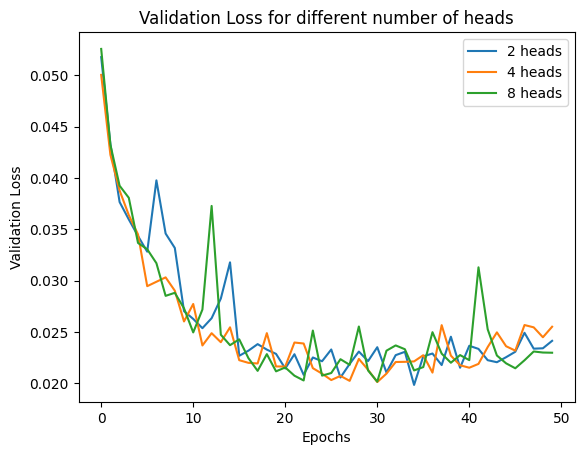

In [ ]:
import matplotlib.pyplot as plt

plt.plot(val_loss_2, label='2 heads')
plt.plot(val_loss_4, label='4 heads')
plt.plot(val_loss_8, label='8 heads')

plt.title('Validation Loss for different number of heads')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

plt.legend()

plt.show()

In [22]:
def inference(model, device, label_embedding, sequence_in):

    model.eval()

    labels_names = ['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa',
       'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn',
       'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk',
       'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut',
       'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt',
       'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead',
       'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx',
       'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nz-dlr',
       'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palm-kernel',
       'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil',
       'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship',
       'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean',
       'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sun-seed',
       'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']
    
    with torch.no_grad():
            sequence_in = torch.tensor(sequence_in).to(device)

            pred_batch = model(sequence_in, label_embedding)

            out = torch.sigmoid(pred_batch.cpu().detach()).numpy().tolist()
            
            out = np.array(out) >= 0.5

            pos = []
            neg = []

            for i, value in enumerate(out[0]) :
                if(value == True) :
                    pos.append(labels_names[i])
                else :
                    neg.append(labels_names[i])

            print("Positive Labels : ", pos)
            # print("Negative Labels : ", neg)
            

In [9]:
with open("/content/drive/MyDrive/MLTC_MAGNET_REUTERS/maxlength.pkl", "rb") as f:
    maxlen = pickle.load(f)

with open("/content/drive/MyDrive/MLTC_MAGNET_REUTERS/word2idx.pkl", "rb") as f:
    word2idx = pickle.load(f)

with open("/content/drive/MyDrive/MLTC_MAGNET_REUTERS/label_embedding.pkl", "rb") as f:
    label_embed = pickle.load(f)

best_model = torch.load('/content/drive/MyDrive/MLTC_MAGNET_REUTERS/reuters_head4.pth')

dev = "cuda" if torch.cuda.is_available() else "cpu"

In [49]:
while True : 
    sample_sentence = input("Enter the sentence : ")
    if(sample_sentence == "exit") :
        break
    sample_sentence = data_preprocessing([sample_sentence])
    vocab_size = len(word2idx)
    sample_sequence = text_to_sequence(sample_sentence, word2idx)
    sample_sequence = padding(sample_sequence, maxlen)
    inference(best_model, dev, label_embed, sample_sequence)

Enter the sentence : The stock market rallied after the Fed announced a new interest rate policy.
Positive Labels :  ['interest', 'money-fx']
Enter the sentence : The pharmaceutical company received approval for a new drug to treat a rare disease.
Positive Labels :  ['acq']
Enter the sentence : The energy sector experienced a surge in demand for renewable energy sources.
Positive Labels :  ['crude']
Enter the sentence : The U.S. Federal Reserve is expected to raise interest rates next month, according to analysts.
Positive Labels :  ['interest']
Enter the sentence : exit
